# Data Collection and Preprocessing
 - Using Fashion-MNSIST Dataset
 - 10 Classes
 - Clothes Dataset


In [ ]:
!pip install torch torchvision torchaudio scikit-learn ucimlrepo matplotlib numpy pandas


In [ ]:
!pip install seaborn

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pds
import kagglehub
from torch.utils.data import Dataset, DataLoader, Subset, random_split, ConcatDataset
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt



# Downloading Dataset and Dataset statistics

Total Dataset Size: 70000
Train Size: 56000
Validation Size: 7000
Test Size: 7000
Training Set: 
Label 9: 5568 samples
Label 6: 5652 samples
Label 5: 5632 samples
Label 3: 5598 samples
Label 8: 5570 samples
Label 7: 5592 samples
Label 1: 5629 samples
Label 4: 5597 samples
Label 2: 5570 samples
Label 0: 5592 samples


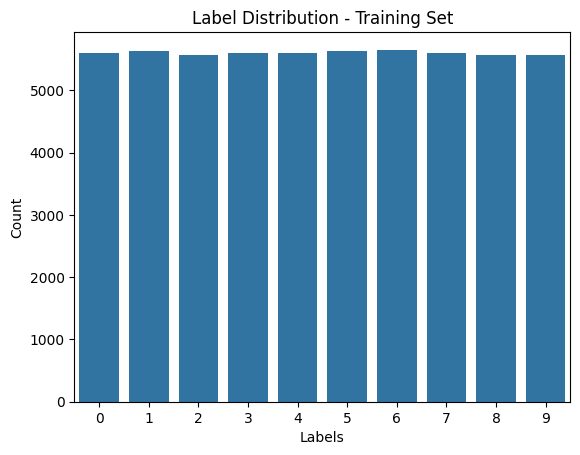

Minimum Pixel Value: 0.0
Maximum Pixel Value: 1.0
Mean Pixel Value: 0.2859440743923187
Standard Deviation: 0.3528888523578644
Validation Set: 
Label 9: 709 samples
Label 4: 696 samples
Label 1: 712 samples
Label 8: 692 samples
Label 6: 663 samples
Label 0: 708 samples
Label 2: 722 samples
Label 7: 702 samples
Label 3: 688 samples
Label 5: 708 samples


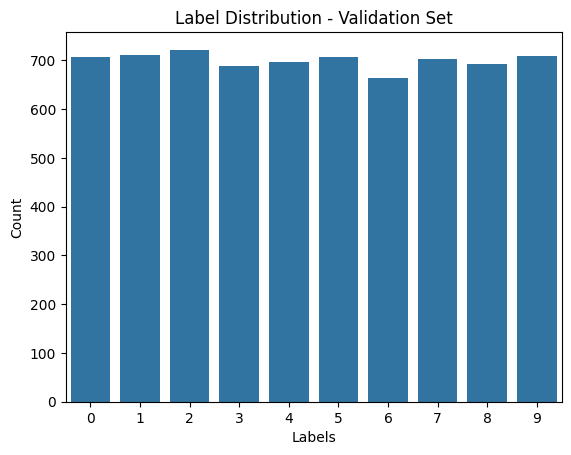

Minimum Pixel Value: 0.0
Maximum Pixel Value: 1.0
Mean Pixel Value: 0.28484046459198
Standard Deviation: 0.3519449830055237
Test Set: 
Label 3: 714 samples
Label 0: 700 samples
Label 9: 723 samples
Label 8: 738 samples
Label 1: 659 samples
Label 6: 685 samples
Label 5: 660 samples
Label 7: 706 samples
Label 4: 707 samples
Label 2: 708 samples


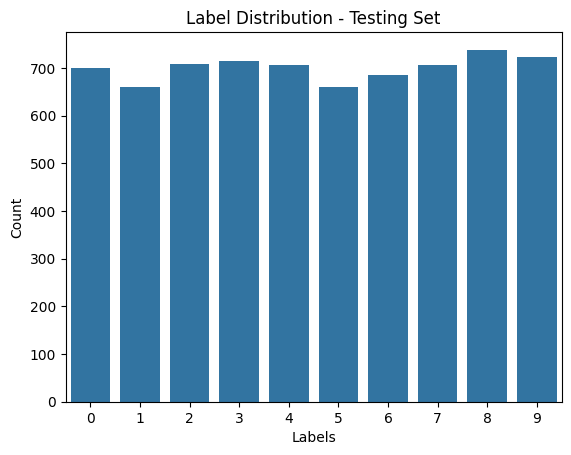

Minimum Pixel Value: 0.0
Maximum Pixel Value: 1.0
Mean Pixel Value: 0.28916823863983154
Standard Deviation: 0.35433968901634216


In [ ]:
# Download Dataset
training_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Ensure Data Split: 80% Train , 10% validation, 10% Test

full_dataset = ConcatDataset([training_data, test_set])

print(f"Total Dataset Size: {len(full_dataset)}")

# Ensure data split
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = int(0.1*len(full_dataset))

print(f"Train Size: {train_size}")
print(f"Validation Size: {val_size}")
print(f"Test Size: {test_size}")


SEED = 42 # Seeding project for repruduciability
torch.manual_seed(SEED)

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])


def label_distribution(data,dataset_name = "Dataset"):
  labels = [x for _, x in data]
  counts = Counter(labels)

  for label, count in counts.items():
    print(f"Label {label}: {count} samples")
  labels_list = list(counts.keys())
  counts_list = list(counts.values())

  sns.barplot(x=labels_list, y=counts_list)
  plt.xlabel("Labels")
  plt.ylabel("Count")
  plt.title(f"Label Distribution - {dataset_name}")
  plt.show()


def feature_image_range(dataset):
  pixels = torch.cat([dataset[i][0].view(-1) for i in range(len(dataset))])

  print(f"Minimum Pixel Value: {pixels.min()}")
  print(f"Maximum Pixel Value: {pixels.max()}")
  print(f"Mean Pixel Value: {pixels.mean()}")
  print(f"Standard Deviation: {pixels.std()}")

# BEFORE DATA PREPROCESSING
print("Training Set: ")
label_distribution(train_set,"Training Set")
feature_image_range(train_set)
print("Validation Set: ")
label_distribution(val_set, "Validation Set")
feature_image_range(val_set)
print("Test Set: ")
label_distribution(test_set, "Testing Set")
feature_image_range(test_set)

# Labeled and unlabled. Training Pool Split And Data Augmentations

- 80% Unlabled
- 20% Labled
